In [108]:
import pyspeckit as ps
from astropy.io import fits
from bokeh.layouts import column

import os

import astropy.units as u
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools
from bokeh.models import Span, Label, Arrow, NormalHead
import numpy as np
output_notebook()
%matplotlib widget

import warnings
#warnings.filterwarnings('ignore')

#f = fits.open('../Observation1/data/FixedAstrometryDATACUBE_FINAL.fits')

#c = ps.Cube(f[1])
#cube1= SpectralCube.read('../Observation1/data/FixedAstrometryDATACUBE_FINAL.fits',hdu=1)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u




##Emission Lines
class line(object):
    def __init__(self,name):
        self.name = name

        
        
##Emission Lines
class specto(object):
    def __init__(self,wave,flux,ra,dec,apperture):
        self.wave = wave
        self.flux = flux
        self.ra = ra
        self.dec = dec
        self.apperture = apperture
    def plot(self,title='b'):
        "Plot with BOkeh"
        x = self.wave
        y = self.flux

        p = figure(plot_width=900, plot_height=500, title=title,active_drag='box_zoom', active_scroll='wheel_zoom')


        p.line(x,y)



        #Tool to get wavelength
        hover2 = HoverTool(
                tooltips=[
                    ("(x,y)", "($x{1}, $y)"),
                ]
            )



        p.add_tools(hover2)

        show(p)



#c = ps.Cube(cube=cube1)

Loading BokehJS ...

# mini try first

Mini datacube:
#mini = spectralcube[:,135:160,190:220]
#mini

In [139]:
def getspectrafromregion(spectralcube,ra,dec,aperture,xmin=6400.,xmax=6650.):
    """Get a dec,ra in hh:mm:ss and aperture in arcsecond"""
    
    
    sourcename = 'tempspectra'
    region = 'fk5; circle({}, {}, {}")'.format(ra,dec,aperture)

    filename = '{}.fits'.format(sourcename)

    #Spectrum
    subcube = spectralcube.subcube_from_ds9region(region)  
    spectrum = subcube.sum(axis=(1, 2)) 


    if os.path.isfile(filename):
        os.remove(filename)
    spectrum.write(filename)
    
    
    pyspec = ps.Spectrum(filename)
    
    os.remove(filename)
    
    
    pyspec.crop(xmin, xmax, unit='angstrom') 
    pyspec.baseline(xmin=xmin, xmax=xmax,exclude=[6520,6600,6660,6700],order=2,subtract=True)

    inds = np.argsort(pyspec.xarr)
    xp2 = pyspec.xarr.value[inds]
    yp2 = pyspec.data[inds]


    x = np.array(xp2)
    y = np.array(yp2)
    
    return specto(x,y,ra,dec,aperture)

def findlines(specto):
    errorindex = np.where( (6400 < specto.wave) &  (6500 > specto.wave) )[0]
    errorflux = specto.flux[errorindex]
    errorstd = np.std(errorflux)
    lineindex = np.where(specto.flux > 3.5* errorstd)[0]
    if len(lineindex) > 2:
        print('Found Line')
        specto.lineindex = lineindex
    else:
        print('Booo')
    

def getlatloglist(spectralcube,latsepa=0.5,logsepa=0.5):
    cubelatextrema = spectralcube.latitude_extrema
    cubelongextrema = spectralcube.longitude_extrema
    seplat = Angle(latsepa*u.arcsec)
    seplog = Angle(logsepa*u.arcsec)

    latlist = np.arange(Angle(cubelatextrema[0]).deg,
                        Angle(cubelatextrema[1]).deg,
                        seplat.deg)

    loglist = np.arange(Angle(cubelongextrema[0]).deg,
                        Angle(cubelongextrema[1]).deg,
                        seplog.deg)

    latloglist = []
    for la in latlist:
        templa = Angle(la*u.deg)    
        for log in loglist:
            templog = Angle(log*u.deg)
            latloglist.append([templa.to_string(unit=u.degree, sep=':'),templog.to_string(unit=u.hour, sep=':')])
    return latloglist


In [145]:
cube = 'mini.fits'
spectralcube= SpectralCube.read(cube,hdu=1)
listlatlog = getlatloglist(spectralcube,latsepa=0.5,logsepa=0.5)


In [151]:
for vaina in listlatlog[0:2]:
    ra = vaina[0]
    dec = vaina[1]
    tryspec = getspectrafromregion(spectralcube,dec, ra, 0.200,xmin=6400.,xmax=6650.)
    tryspec.plot()


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
This function (<function BaseSpectralCube.sum at 0x7f72fe463268>) requires loading the entire cube into memory and may therefore be slow.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
This function (<function BaseSpectralCube.sum at 0x7f72fe463268>) requires loading the entire cube into memory and may therefore be slow.


In [148]:
ra

'-53:40:22.6137'

In [149]:
dec

'17:40:41.4401'

In [34]:
cube = 'FixedAstrometryDATACUBE_FINAL.fits'
spectralcube= SpectralCube.read(cube,hdu=1)
tryspec = getspectrafromregion(spectralcube,'17:40:41.6001', '-53:40:19.233', 0.200,xmin=6400.,xmax=6650.)
findlines(tryspec)

'10**(-20)*erg/s/cm**2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
This function (<function BaseSpectralCube.sum at 0x7f72fe463268>) requires loading the entire cube into memory and may therefore be slow.


Found Line


In [77]:

c = SkyCoord('17h40m41.60s', '-53d40m19.233s', frame='fk5')
sep = SkyCoord('17h40m41.60s', '-0d0m19.233s', frame='fk5')
t= 1*u.arcsec

In [83]:
tt = Angle(t)
tt

<Angle 1. arcsec>

In [100]:
 Angle(mini.latitude_extrema[0]).deg

-53.67294825676275

In [133]:
cubelatextrema = mini.latitude_extrema
cubelongextrema = mini.longitude_extrema
seplat = Angle(0.5*u.arcsec)
seplog = Angle(0.5*u.arcsec)

latlist = np.arange(Angle(cubelatextrema[0]).deg,
                    Angle(cubelatextrema[1]).deg,
                    seplat.deg)

loglist = np.arange(Angle(cubelongextrema[0]).deg,
                    Angle(cubelongextrema[1]).deg,
                    seplog.deg)

latloglist = []
for la in latlist:
    templa = Angle(la*u.deg)    
    for log in loglist:
        templog = Angle(log*u.deg)
        latloglist.append([templa.to_string(unit=u.degree, sep=':'),templog.to_string(unit=u.hour, sep=':')])

In [135]:
for

['-53:40:22.6137', '17:40:41.4401']

In [132]:
latloglist = []
for la in latlist:
    templa = Angle(la*u.deg)    
    for log in loglist:
        templog = Angle(log*u.deg)
        latloglist.append([templa.to_string(unit=u.degree, sep=':'),templog.to_string(unit=u.hour, sep=':')])

In [112]:
len(loglist)

20

In [113]:
len(latlist)

10

In [43]:
errorindex = np.where( (6400 < tryspec.wave) &  (6500 > tryspec.wave) )[0]
errorflux = tryspec.flux[errorindex]
errorstd = np.std(errorflux)
np.where(tryspec.flux > 3.5* errorstd)

(array([106, 107, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146]),)

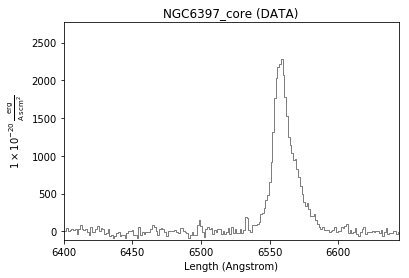

In [39]:
tryspec.crop(6400., 6650, unit='angstrom') 
tryspec.baseline(xmin=6000, xmax=7000,exclude=[6520,6600,6660,6700],order=2,subtract=True, highlight_fitregion=True)

#skysubstractedpyspec.baseline(exclude=[4000,5000,6450,6746,6815,6884,7003,7126,7506,7674,8142,8231], order=5,subtract=False, highlight_fitregion=True)
#tryspec.baseline(xmin=6000, xmax=7000,exclude=[6520,6600,6660,6700],order=2,subtract=True, highlight_fitregion=True)

tryspec.plotter()

In [41]:


#Plot 2
##Second plot
# create a new plot
p = figure(plot_width=900, plot_height=500, title='a',active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers

inds = np.argsort(tryspec.xarr)
xp2 = tryspec.xarr.value[inds]
yp2 = tryspec.data[inds]

p.line(xp2,yp2)

x = np.array(xp2)
y = np.array(yp2)

        
        
#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )

        
        
p.add_tools(hover2)

show(p)

In [32]:
sourcename = 'U23'
region = 'fk5; circle(17:40:41.6001, -53:40:19.233, 0.200")'
backgroundreg = 'fk5; circle(17:40:41.6667, -53:40:18.076, 0.200")'

filename = '{}.fits'.format(sourcename)
filenamesky = '{}sky.fits'.format(sourcename)
diclines = {line('H'+u"\u03B1"):6563}
plotlines = 'True'

#Spectrum
subcube = cube1.subcube_from_ds9region(region)  
spectrum = subcube.sum(axis=(1, 2)) 

#Sky
subcubesky = cube1.subcube_from_ds9region(backgroundreg)  
spectrumsky = subcubesky.sum(axis=(1, 2)) 

if os.path.isfile(filename):
    os.remove(filename)
spectrum.write(filename)



if os.path.isfile(filenamesky):
    os.remove(filenamesky)
spectrumsky.write(filenamesky)



###
#Substarct the sky
pyspec = ps.Spectrum(filename)
pyspecsky = ps.Spectrum(filenamesky)

skysubstractedpyspec = pyspec - pyspecsky

        
#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )

        


# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='pan', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)







##Second plot
# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)



#Plot 2
##Second plot
# create a new plot
p2 = figure(plot_width=900, plot_height=500, title=sourcename+'no sky',active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers

inds = np.argsort(skysubstractedpyspec.xarr)
xp2 = skysubstractedpyspec.xarr.value[inds]
yp2 = skysubstractedpyspec.data[inds]

p2.line(xp2,yp2)

x = np.array(xp2)
y = np.array(yp2)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p2.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p2.add_layout(my_label)


p2.add_tools(hover2)



inds = np.argsort(skysubstractedpyspec.xarr)


#Build gaussian

skysubstractedpyspec.plotter()


skysubstractedpyspec.crop(6400., 7000, unit='angstrom') 


#skysubstractedpyspec.baseline(exclude=[4000,5000,6450,6746,6815,6884,7003,7126,7506,7674,8142,8231], order=5,subtract=False, highlight_fitregion=True)
skysubstractedpyspec.baseline(xmin=6000, xmax=7000,exclude=[6520,6600,6660,6700],order=2,subtract=True, highlight_fitregion=True)



#skysubstractedpyspec.plotter(xmin=6100,xmax=7000)



#skysubstractedpyspec.plotter()

skysubstractedpyspec.specfit(guesses=[4500.,6564.,10.], 
             fittype='gaussian', show_components=True, annotate =True)



skysubstractedpyspec.plotter.refresh()


#Show plots
show(column(p,p2))

NameError: name 'cube1' is not defined

In [2]:
skysubstractedpyspec.specfit.print_fit()

NameError: name 'skysubstractedpyspec' is not defined

In [49]:
print(skysubstractedpyspec.specfit.EQW())

-11.628549072201615


In [50]:
print(skysubstractedpyspec.specfit.measure_approximate_fwhm())

10.0 Angstrom


# U23 try 2

In [33]:
sourcename = 'U23'
region = 'fk5; circle(17:40:41.5987, -53:40:19.615, 0.200")'
backgroundreg = 'fk5; circle(17:40:41.6667, -53:40:18.076, 0.200")'

filename = '{}.fits'.format(sourcename)
filenamesky = '{}sky.fits'.format(sourcename)
diclines = {line('H'+u"\u03B1"):6563}
plotlines = 'True'

#Spectrum
subcube = cube1.subcube_from_ds9region(region)  
spectrum = subcube.sum(axis=(1, 2)) 

#Sky
subcubesky = cube1.subcube_from_ds9region(backgroundreg)  
spectrumsky = subcubesky.sum(axis=(1, 2)) 

if os.path.isfile(filename):
    os.remove(filename)
spectrum.write(filename)



if os.path.isfile(filenamesky):
    os.remove(filenamesky)
spectrumsky.write(filenamesky)



###
#Substarct the sky
pyspec = ps.Spectrum(filename)
pyspecsky = ps.Spectrum(filenamesky)

skysubstractedpyspec = pyspec - pyspecsky

        
#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )

        


# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='pan', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)







##Second plot
# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)



#Plot 2
##Second plot
# create a new plot
p2 = figure(plot_width=900, plot_height=500, title=sourcename+'no sky',active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers

inds = np.argsort(skysubstractedpyspec.xarr)
xp2 = skysubstractedpyspec.xarr.value[inds]
yp2 = skysubstractedpyspec.data[inds]

p2.line(xp2,yp2)

x = np.array(xp2)
y = np.array(yp2)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p2.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p2.add_layout(my_label)


p2.add_tools(hover2)



inds = np.argsort(skysubstractedpyspec.xarr)


#Build gaussian

skysubstractedpyspec.plotter()


skysubstractedpyspec.crop(6400., 7000, unit='angstrom') 


#skysubstractedpyspec.baseline(exclude=[4000,5000,6450,6746,6815,6884,7003,7126,7506,7674,8142,8231], order=5,subtract=False, highlight_fitregion=True)
skysubstractedpyspec.baseline(xmin=6000, xmax=7000,exclude=[6520,6600,6660,6700],order=2,subtract=True, highlight_fitregion=True)



#skysubstractedpyspec.plotter(xmin=6100,xmax=7000)



#skysubstractedpyspec.plotter()

skysubstractedpyspec.specfit(guesses=[1500.,6550.,1.,1500.,6580.,1.], 
             fittype='gaussian', show_components=True, annotate =True)



skysubstractedpyspec.plotter.refresh()


#Show plots
show(column(p,p2))

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
This function (<function BaseSpectralCube.sum at 0x7fe32ab5f840>) requires loading the entire cube into memory and may therefore be slow.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

FigureCanvasNbAgg()


Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


In [101]:
import numpy as np




sp = ps.Spectrum(
        xarr=ps.units.SpectroscopicAxis(np.linspace(-50,50,101),
            unit='km/s', refX=6562.8, refX_unit='angstrom'),
        data=np.random.randn(101), error=np.ones(101))



sp.plotter()

FigureCanvasNbAgg()

In [70]:
skysubstractedpyspec.plotter()

FigureCanvasNbAgg()

In [59]:
inds = np.argsort(skysubstractedpyspec.xarr)

In [60]:
inds

array([   0,    1,    2, ..., 3679, 3680, 3681])

# U19 (CV2)

Observed with HST on 1996 by Grindlay et al.

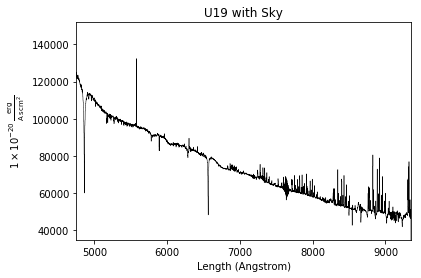

In [6]:
u19og = c.get_apspec((181.6097, 104.21333, 2.09), method='sum') 




# start by plotting a small region around the H-alpha line
u19og.plotter(title='U19 with Sky')




In [10]:
spectrum.write('aaaa.fits')

In [3]:
ds9_str = 'fk5; circle(17:40:42.3067, -53:40:28.952, 0.218")'
subcube = cube1.subcube_from_ds9region(ds9_str)  
spectrum = subcube.sum(axis=(1, 2)) 

# create a new plot
p = figure(plot_width=900, plot_height=500, title="U19",active_drag='pan', active_scroll='wheel_zoom')

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )


#plot Lines


##Emission Lines
class line(object):
    def __init__(self,name):
        self.name = name


# add some renderers
p.line(cube1.spectral_axis,spectrum)



diclines = {line('H'+u"\u03B1"):6563}

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc - 3005, x_end = xloc, y_end= yloc-.03
            )
    #p.add_layout(span)
    #my_label = Label(x=xloc, y=yloc-3000, text=name.name)
    #p.add_layout(my_label)

p2.add_tools(hover2)

show(p)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
This function (<function BaseSpectralCube.sum at 0x7f4a1b04a400>) requires loading the entire cube into memory and may therefore be slow.


In [ ]:
back = c.get_apspec((169.85975, 118.10193, 1.08), method='average')   
u19msky = u19og-back
u19msky.plotter(title='U19 with no Sky')

# U23

In [41]:
ds9_str = 'fk5; circle(17:40:41.6001, -53:40:19.233, 0.20")'
subcube = cube1.subcube_from_ds9region(ds9_str)  
spectrum = subcube.sum(axis=(1, 2)) 

# create a new plot
p = figure(plot_width=900, plot_height=500, title="U23",active_drag='pan', active_scroll='wheel_zoom')

#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )


#plot Lines


##Emission Lines
class line(object):
    def __init__(self,name):
        self.name = name


# add some renderers
p.line(cube1.spectral_axis,spectrum)



diclines = {line('H'+u"\u03B1"):6563}

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc - 3005, x_end = xloc, y_end= yloc-.03
            )
    #p.add_layout(span)
    #my_label = Label(x=xloc, y=yloc-3000, text=name.name)
    #p.add_layout(my_label)





p.add_tools(hover2)

show(p)

In [43]:
u23og = c.get_apspec((213.00414, 152.80779, 1.00), method='sum') 




# start by plotting a small region around the H-alpha line
u23og.plotter(title='U23 with Sky')




FigureCanvasNbAgg()

# U24

In [14]:
sourcename = 'U24'
region = 'fk5; circle(17:40:41.4680 -53:40:04.430, 0.200")'
backgroundreg = 'fk5; circle(17:40:41.3791, -53:40:04.019, 0.200")'

filename = '{}.fits'.format(sourcename)
filenamesky = '{}sky.fits'.format(sourcename)
diclines = {line('H'+u"\u03B1"):6563}
plotlines = 'True'

#Spectrum
subcube = cube1.subcube_from_ds9region(region)  
spectrum = subcube.sum(axis=(1, 2)) 

#Sky
subcubesky = cube1.subcube_from_ds9region(backgroundreg)  
spectrumsky = subcubesky.sum(axis=(1, 2)) 

if os.path.isfile(filename):
    os.remove(filename)
spectrum.write(filename)



if os.path.isfile(filenamesky):
    os.remove(filenamesky)
spectrumsky.write(filenamesky)



###
#Substarct the sky
pyspec = ps.Spectrum(filename)
pyspecsky = ps.Spectrum(filenamesky)

skysubstractedpyspec = pyspec - pyspecsky

        
#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )

        


# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='pan', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)







##Second plot
# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)



#Plot 2
##Second plot
# create a new plot
p2 = figure(plot_width=900, plot_height=500, title=sourcename+'no sky',active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers

inds = np.argsort(skysubstractedpyspec.xarr)
xp2 = skysubstractedpyspec.xarr.value[inds]
yp2 = skysubstractedpyspec.data[inds]

p2.line(xp2,yp2)

x = np.array(xp2)
y = np.array(yp2)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p2.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p2.add_layout(my_label)


p2.add_tools(hover2)



inds = np.argsort(skysubstractedpyspec.xarr)


#Build gaussian

skysubstractedpyspec.plotter()


skysubstractedpyspec.crop(6400., 7000, unit='angstrom') 


#skysubstractedpyspec.baseline(exclude=[4000,5000,6450,6746,6815,6884,7003,7126,7506,7674,8142,8231], order=5,subtract=False, highlight_fitregion=True)
skysubstractedpyspec.baseline(xmin=6000, xmax=7000,exclude=[6520,6600,6660,6700],order=2,subtract=True, highlight_fitregion=True)



#skysubstractedpyspec.plotter(xmin=6100,xmax=7000)



#skysubstractedpyspec.plotter()

skysubstractedpyspec.specfit(guesses=[4500.,6564.,10.], 
             fittype='gaussian', show_components=True, annotate = False)



skysubstractedpyspec.plotter.refresh()


#Show plots
show(column(p,p2))

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
This function (<function BaseSpectralCube.sum at 0x7fe32ab5f840>) requires loading the entire cube into memory and may therefore be slow.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

FigureCanvasNbAgg()

# U25

In [12]:
sourcename = 'U25'
region = 'fk5; circle(17:40:41.2370, -53:40:25.790, 0.200")'
backgroundreg = 'fk5; circle(17:40:41.2193, -53:40:25.072, 0.200")'

filename = '{}.fits'.format(sourcename)
filenamesky = '{}sky.fits'.format(sourcename)
diclines = {line('H'+u"\u03B1"):6563}
plotlines = 'True'

#Spectrum
subcube = cube1.subcube_from_ds9region(region)  
spectrum = subcube.sum(axis=(1, 2)) 

#Sky
subcubesky = cube1.subcube_from_ds9region(backgroundreg)  
spectrumsky = subcubesky.sum(axis=(1, 2)) 

if os.path.isfile(filename):
    os.remove(filename)
spectrum.write(filename)



if os.path.isfile(filenamesky):
    os.remove(filenamesky)
spectrumsky.write(filenamesky)



###
#Substarct the sky
pyspec = ps.Spectrum(filename)
pyspecsky = ps.Spectrum(filenamesky)

skysubstractedpyspec = pyspec - pyspecsky

        
#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("(x,y)", "($x{1}, $y)"),
        ]
    )

        


# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='pan', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)







##Second plot
# create a new plot
p = figure(plot_width=900, plot_height=500, title=sourcename,active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers
p.line(cube1.spectral_axis,spectrum)

x = np.array(cube1.spectral_axis)
y = np.array(spectrum)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p.add_layout(my_label)


p.add_tools(hover2)



#Plot 2
##Second plot
# create a new plot
p2 = figure(plot_width=900, plot_height=500, title=sourcename+'no sky',active_drag='box_zoom', active_scroll='wheel_zoom')


#plot Lines

# add some renderers

inds = np.argsort(skysubstractedpyspec.xarr)
xp2 = skysubstractedpyspec.xarr.value[inds]
yp2 = skysubstractedpyspec.data[inds]

p2.line(xp2,yp2)

x = np.array(xp2)
y = np.array(yp2)
for name, xloc in diclines.items():
    yloc = y[np.where(abs(xloc - x) < 2)[0][0]]
    span = Arrow(end=NormalHead(fill_color='orange', size=10),
             x_start=xloc, y_start = yloc + 2005, x_end = xloc, y_end= yloc+1000
            )
    if plotlines == 'True':
        p2.add_layout(span)
        my_label = Label(x=xloc-1, y=yloc+2000, text=name.name)
        p2.add_layout(my_label)


p2.add_tools(hover2)



inds = np.argsort(skysubstractedpyspec.xarr)


#Build gaussian

skysubstractedpyspec.plotter()


skysubstractedpyspec.crop(6400., 7000, unit='angstrom') 


#skysubstractedpyspec.baseline(exclude=[4000,5000,6450,6746,6815,6884,7003,7126,7506,7674,8142,8231], order=5,subtract=False, highlight_fitregion=True)
skysubstractedpyspec.baseline(xmin=6000, xmax=7000,exclude=[6520,6600,6660,6700],order=2,subtract=False, highlight_fitregion=True)



#skysubstractedpyspec.plotter(xmin=6100,xmax=7000)



#skysubstractedpyspec.plotter()

skysubstractedpyspec.specfit(guesses=[4500.,6564.,10.], 
             fittype='gaussian', show_components=True, annotate = False)



skysubstractedpyspec.plotter.refresh()


#Show plots
show(column(p,p2))

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
This function (<function BaseSpectralCube.sum at 0x7fe32ab5f840>) requires loading the entire cube into memory and may therefore be slow.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)

FigureCanvasNbAgg()